In [1]:
# !wget -c "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
# !wget -c "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
# !wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz"
# !unzip -o glove.twitter.27B.zip

In [2]:
# !pip install -U sentence-transformers
# !pip install --upgrade Gensim
# !pip install fuzzywuzzy
# !pip install --upgrade networkx
# !pip install imblearn
# !pip install wordcloud
# exit()

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import re
import hashlib
from fuzzywuzzy import fuzz
from IPython.display import display
from collections import defaultdict
from matplotlib import pyplot
import networkx as nx
import time
import sys
from functools import reduce

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import load_facebook_model
from transformers import XLNetTokenizer, XLNetModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import Birch

from wordcloud import WordCloud

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/subhailamathy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/subhailamathy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import pandas as pd

# Input text
text = ["What are the natural numbers"]

# Bag of Words
cv = CountVectorizer()
bow = cv.fit_transform(text)
bow_df = pd.DataFrame(bow.toarray(), columns=cv.get_feature_names_out())

# TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(text)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Word2Vec
# Using Gensim's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin.gz', binary=True
)

# Tokenize the sentence
words = text[0].split()

# Get the vector for each word in the sentence
word2vec_vectors = {word: word2vec[word] for word in words if word in word2vec}

# Display results
bow_df, tfidf_df, word2vec_vectors

print(word2vec_vectors['What'].shape)

KeyboardInterrupt: 

In [14]:
print(word2vec_vectors['numbers'][0:3])

[0.28125    0.08691406 0.16210938]


In [9]:
 # _ = glove2word2vec("glove.twitter.27B.200d.txt", "glove.txt")#Transform glove model to a word2vec format

In [2]:
data = pd.read_csv('quora_duplicate_questions.tsv', delimiter='\t'
                   ).dropna(how='any').reset_index(drop=True)
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
#Global constants
SAFE_DIV = 0.0001
NB_CORES = 10
FREQ_UPPER_BOUND = 100
NEIGHBOR_UPPER_BOUND = 5
MAX_ITER = 20

WORD2VEC_MODELS = [['GoogleNews-vectors-negative300.bin.gz','_word2vec_googlenews', '_clean', True], 
                   ['glove.txt', '_glove', '_clean', False]]
BERT_MODELS = [['distilbert-base-nli-stsb-quora-ranking', '_bert_base', '_clean']]

**Explore** **data**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: xlabel='is_duplicate'>

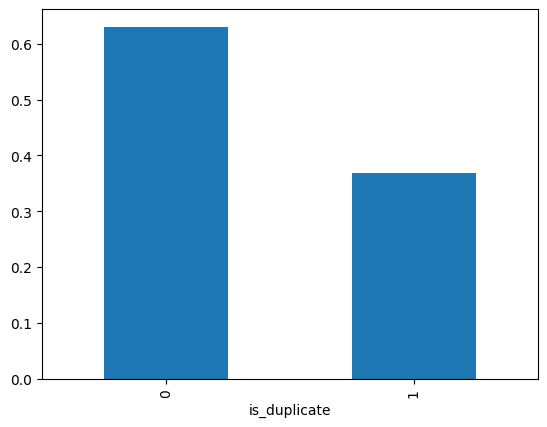

In [4]:
data['is_duplicate'].value_counts(normalize=True).plot.bar()

**Preprocessing**

In [5]:
class Preprocess:

    def __init__(self, frac):
        """Initialize the Preprocessor
        args:
         frac
           The fraction of random data to use during preprocessing
        """

        self.frac = frac

    def sample_data(self):
        global data
        data = data.groupby('is_duplicate').apply(lambda x: \
                x.sample(frac=self.frac))

    def preprocessing_text(self, txt):
        txt = txt.lower()
        txt = txt.replace(',000,000', 'm').replace(',000', 'k'
                ).replace('\xe2\x80\xb2', "'").replace('\xe2\x80\x99',
                "'").replace("can't", 'cannot').replace("don't",
                'do not').replace("isn't", 'is not').replace("you're",
                'you are').replace("you've", 'you have'
                                   ).replace("you'll", 'you will'
                ).replace("that'll", 'that will').replace("should've",
                'should have').replace("aren't", 'are not'
                ).replace("couldn't", 'could not').replace("didn't",
                'did not').replace("doesn't", 'does not'
                                   ).replace("hadn't", 'had not'
                ).replace("hasn't", 'has not').replace("haven't",
                'have not').replace("mustn't", 'must not'
                                    ).replace("wasn't", 'was not'
                ).replace("i'm", 'i am').replace("he's", 'he is'
                ).replace("she's", 'she is').replace("ain't", 'am not'
                ).replace('%', ' percent ').replace('\xe2\x82\xb9',
                ' rupee ').replace('$', ' dollar '
                                   ).replace('\xe2\x82\xac', ' euro '
                ).replace("'ll", ' will').replace("'ve", ' have'
                ).replace("it's", 'it is')

        txt = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", ' ', txt)
        txt = re.sub(r"\'s", " 's ", txt)
        txt = re.sub(r"\'ve", " 've ", txt)
        txt = re.sub(r"n\'t", " 't ", txt)
        txt = re.sub(r"\'re", " 're ", txt)
        txt = re.sub(r"\'d", " 'd ", txt)
        txt = re.sub(r"\'ll", " 'll ", txt)
        txt = re.sub(r",", ' ', txt)
        txt = re.sub(r"\.", ' ', txt)
        txt = re.sub(r"!", ' ', txt)
        txt = re.sub(r"\(", ' ( ', txt)
        txt = re.sub(r"\)", ' ) ', txt)
        txt = re.sub(r"\?", ' ', txt)
        txt = re.sub(r"\s{2,}", ' ', txt)
        text_tokens = word_tokenize(txt)
        tokens_without_sw = [word for word in text_tokens if word not
                             in stop_words and len(word) != 1]
        txt = ' '.join(tokens_without_sw)
        txt = stemmer.stem(txt)

        return txt

    def run(self):
        global data
        self.sample_data()
        data['question1_clean'] = data['question1'
                ].apply(self.preprocessing_text)
        data['question2_clean'] = data['question2'
                ].apply(self.preprocessing_text)

**Get NLP features**

In [6]:
class Nlp_Features:

    def get_nlp_features(self):
        global data
        q1_tokens = str(data["question1"]).split()
        q2_tokens = str(data["question2"]).split()
        q1_words = set([word for word in q1_tokens if word
                       not in stop_words])
        q2_words = set([word for word in q2_tokens if word
                       not in stop_words])
        q1_stops = set([word for word in q1_tokens if word
                       not in stop_words])
        q2_stops = set([word for word in q2_tokens if word
                       in stop_words])
        common_word_count = len(q1_words.intersection(q2_words))
        common_stop_count = len(q1_stops.intersection(q2_stops))
        common_token_count = \
            len(set(q1_tokens).intersection(set(q2_tokens)))
        data['len_q1'] = np.nan_to_num(data["question1"].apply(lambda x: \
                len(str(x))))
        data['len_q2'] = np.nan_to_num(data["question2"].apply(lambda x: \
                len(str(x))))
        data['diff_len'] = np.nan_to_num(data.len_q1 - data.len_q2)
        data['len_char_q1'] = \
            np.nan_to_num(data["question1"].apply(lambda x: \
                          len(''.join(set(str(x).replace(' ', ''))))))
        data['len_char_q2'] = \
            np.nan_to_num(data["question2"].apply(lambda x: \
                          len(''.join(set(str(x).replace(' ', ''))))))
        data['len_word_q1'] = \
            np.nan_to_num(data["question1"].apply(lambda x: \
                          len(str(x).split())))
        data['len_word_q2'] = \
            np.nan_to_num(data["question2"].apply(lambda x: \
                          len(str(x).split())))
        data['cwc_min'] = np.nan_to_num(common_word_count
                / (min(len(q1_words), len(q2_words)) + SAFE_DIV))
        data['cwc_max'] = np.nan_to_num(common_word_count
                / (max(len(q1_words), len(q2_words)) + SAFE_DIV))
        data['csc_min'] = np.nan_to_num(common_stop_count
                / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV))
        data['csc_max'] = np.nan_to_num(common_stop_count
                / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV))
        data['ctc_min'] = np.nan_to_num(common_token_count
                / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
        data['ctc_max'] = np.nan_to_num(common_token_count
                / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV))
        data['last_word_eq'] = np.nan_to_num(int(q1_tokens[-1]
                == q2_tokens[-1]))
        data['first_word_eq'] = np.nan_to_num(int(q1_tokens[0]
                == q2_tokens[0]))
        data['abs_len_diff'] = np.nan_to_num(abs(len(q1_tokens)
                - len(q2_tokens)))
        data['mean_len'] = np.nan_to_num((len(q1_tokens)
                + len(q2_tokens)) / 2)

    def get_fuzzy_features(self):
        global data
        data['fuzz_ratio'] = np.nan_to_num(data.apply(lambda x: \
                fuzz.ratio(str(x['question1']), str(x['question2'])),
                axis=1))
        data['fuzz_partial_ratio'] = np.nan_to_num(data.apply(lambda x: \
                fuzz.partial_ratio(str(x['question1']),
                str(x['question2'])), axis=1))
        data['fuzz_partial_token_set_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.partial_token_set_ratio(str(x['question1'
                          ]), str(x['question2'])), axis=1))
        data['fuzz_partial_token_sort_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.partial_token_sort_ratio(str(x['question1'
                          ]), str(x['question2'])), axis=1))
        data['fuzz_token_set_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.token_set_ratio(str(x['question1']),
                          str(x['question2'])), axis=1))
        data['fuzz_token_sort_ratio'] = \
            np.nan_to_num(data.apply(lambda x: \
                          fuzz.token_sort_ratio(str(x['question1']),
                          str(x['question2'])), axis=1))

    def get_features(self):
        self.get_nlp_features()
        self.get_fuzzy_features()


**Get Graph features**

In [7]:
class Graphic_Features:

    def create_question_hash(self):
        train_qs = np.dstack([data['question1'], data['question2'
                             ]]).flatten()
        train_qs = pd.DataFrame(train_qs)[0].drop_duplicates()
        train_qs.reset_index(inplace=True, drop=True)
        question_dict = pd.Series(train_qs.index.values,
                                  index=train_qs.values).to_dict()
        return question_dict

    def get_hash(self, hash_dict):
        data['qid1_hash'] = np.nan_to_num(data['question1'
                ].map(hash_dict))
        data['qid2_hash'] = np.nan_to_num(data['question2'
                ].map(hash_dict))

    def get_kcore_dict(self):
        g = nx.Graph()
        g.add_nodes_from(data.qid1_hash)
        edges = list(data[['qid1_hash', 'qid2_hash'
                     ]].to_records(index=False))
        g.add_edges_from(edges)
        g.remove_edges_from(list(nx.selfloop_edges(g)))
        df_output = pd.DataFrame(data=g.nodes(), columns=['qid'])
        df_output['kcore'] = 0
        for k in range(2, NB_CORES + 1):
            ck = nx.k_core(g, k=k).nodes()
            df_output.loc[df_output.qid.isin(ck), 'kcore'] = k

        return df_output.to_dict()['kcore']

    def get_kcore_features(self, kcore_dict):
        data['kcore1'] = np.nan_to_num(data['qid1_hash'
                ].apply(lambda x: kcore_dict[x]))
        data['kcore2'] = np.nan_to_num(data['qid2_hash'
                ].apply(lambda x: kcore_dict[x]))

    def convert_to_minmax(self, col):
        sorted_features = np.sort(np.vstack([data[col + '1'], data[col
                                  + '2']]).T)
        data['min_' + col] = sorted_features[:, 0]
        data['max_' + col] = sorted_features[:, 1]
        return data.drop([col + '1', col + '2'], axis=1)

    def get_neighbors(self):
        neighbors = defaultdict(set)
        for df in data:
            for (q1, q2) in zip(data['qid1_hash'], data['qid2_hash']):
                neighbors[q1].add(q2)
                neighbors[q2].add(q1)
        return neighbors

    def get_neighbor_features(self, neighbors):
        common_nc = data.apply(lambda x: \
                               len(neighbors[x.qid1].intersection(neighbors[x.qid2])),
                               axis=1)
        min_nc = data.apply(lambda x: min(len(neighbors[x.qid1]),
                            len(neighbors[x.qid2])), axis=1)
        data['common_neighbor_ratio'] = np.nan_to_num(common_nc
                / min_nc)
        data['common_neighbor_count'] = \
            np.nan_to_num(common_nc.apply(lambda x: min(x,
                          NEIGHBOR_UPPER_BOUND)))

    def pagerank(self, neighbors):
        d = 0.85
        pagerank_dict = {i: 1/len(neighbors) for i in neighbors}
        num_nodes = len(pagerank_dict)

        for iter in range(0, MAX_ITER):

            for node in neighbors:
                local_pr = 0

                for neighbor in neighbors[node]:
                    local_pr += pagerank_dict[neighbor] \
                        / len(neighbors[neighbor])

                pagerank_dict[node] = (1 - d) / num_nodes + d * local_pr
        data['q1_pr'] = np.nan_to_num(data['qid1_hash'].apply(lambda x: \
                pagerank_dict[x]))
        data['q2_pr'] = np.nan_to_num(data['qid2_hash'].apply(lambda x: \
                pagerank_dict[x]))

    def get_features(self):
        global data
        question_dict = self.create_question_hash()
        self.get_hash(question_dict)
        kcore_dict = self.get_kcore_dict()
        self.get_kcore_features(kcore_dict)
        self.convert_to_minmax('kcore')
        neighbors = self.get_neighbors()
        self.pagerank(neighbors)
        self.get_neighbor_features(neighbors)

***Create Embeddings and distances***

In [8]:
class Embedding:

    def tfidf(self):
        questions = list(data['question1' + self.clean]) \
            + list(data['question2' + self.clean])
        tfidf = TfidfVectorizer(lowercase=False)
        tfidf.fit_transform(questions)
        word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
        return word2tfidf

    def distance(self, w2v_q1, w2v_q2):
        global data
        data['cosine_distance' + str(self.name) + str(self.clean)] = \
            [cosine(x, y) for (x, y) in np.nan_to_num(zip(w2v_q1,
             w2v_q2))]
        data['cityblock_distance' + str(self.name) + str(self.clean)] = \
            [cityblock(x, y) for (x, y) in np.nan_to_num(zip(w2v_q1,
             w2v_q2))]
        data['jaccard_distance' + str(self.name) + str(self.clean)] = \
            [jaccard(x, y) for (x, y) in np.nan_to_num(zip(w2v_q1,
             w2v_q2))]
        data['canberra_distance' + str(self.name) + str(self.clean)] = \
            [canberra(x, y) for (x, y) in np.nan_to_num(zip(w2v_q1,
             w2v_q2))]
        data['euclidean_distance' + str(self.name) + str(self.clean)] = \
            [euclidean(x, y) for (x, y) in np.nan_to_num(zip(w2v_q1,
             w2v_q2))]
        data['minkowski_distance' + str(self.name) + str(self.clean)] = \
            [minkowski(x, y, 3) for (x, y) in np.nan_to_num(zip(w2v_q1,
             w2v_q2))]
        data['braycurtis_distance' + str(self.name)
             + str(self.clean)] = [braycurtis(x, y) for (x, y) in
                                   np.nan_to_num(zip(w2v_q1, w2v_q2))]

    def vectors(self, s):
        pass

    def get_distances(self):
        global data
        w2v_q1 = np.array([self.vectors(q) for q in data['question1' + str(self.clean)]])
        w2v_q2 = np.array([self.vectors(q) for q in data['question2' + str(self.clean)]])
        self.distance(w2v_q1, w2v_q2)


class Word2vec_Embdedding(Embedding):

    def __init__(
        self,
        path,
        name,
        clean,
        binary,
        ):
        self.binary = binary
        self.path = path
        self.name = name
        self.clean = clean
        self.model = \
            gensim.models.KeyedVectors.load_word2vec_format(self.path,
                binary=self.binary)

    def vectors(self, s):
        M = []
        input = word_tokenize(str(s))
        for w in input:
            try:
                M.append(self.model[w])
            except:
                continue
        
        if len(M) == 0:
            return np.zeros(self.model.vector_size, dtype=float)
        
        M = np.array(M, dtype=float)
        v = M.sum(axis=0)
        
        out = v / np.sqrt((v ** 2).sum())
        out = np.nan_to_num(out)
    
        return out

    def vectors_weighted(self, s):
        #TODO
        pass


class Bert_Embedding(Embedding):

    def __init__(
        self,
        path,
        name,
        clean,
        ):
        self.path = path
        self.name = name
        self.clean = clean
        self.model = SentenceTransformer(self.path)

    def vectors(self, s):
        return np.nan_to_num(np.array(self.model.encode(s)))


class Embedding_Builder():

    def run(self):
        for model in BERT_MODELS:
            Bert_Embedding(model[0], model[1], model[2]).get_distances()
        for model in WORD2VEC_MODELS:
            Word2vec_Embdedding(model[0], model[1], model[2],
                                model[3]).get_distances()

In [9]:
class Init_Pipeline:

    def __init__(self, frac, first):
        self.frac = frac
        self.first = first

    def run(self):
        global data
        start = time.time()
        data = pd.read_csv('quora_duplicate_questions.tsv',
                           delimiter='\t').dropna(how='any'
                ).reset_index(drop=True)
        Preprocess(self.frac).run()
        Nlp_Features().get_features()
        Graphic_Features().get_features()
        Embedding_Builder().run()
        data.drop(['question1', 'question2', 'question1_clean',
                  'question2_clean'], axis=1, inplace=True)

        if self.first:
            seconds = (time.time() - start) / self.frac
            days = seconds // 86400
            seconds = seconds - days * 86400
            hours = seconds // 3600
            seconds = seconds - hours * 3600
            minutes = seconds // 60
            seconds = seconds - minutes * 60
            out1 = 'Estimated time to run the programm on all Data: ' \
                + str(days) + ' Days ' + str(hours) + ' Hours ' \
                + str(minutes) + ' Minutes ' + str(seconds) \
                + ' seconds '
            out2 = 'Estimated final Data size ' \
                + str(sys.getsizeof(data) / self.frac / 1000000000) \
                + ' GB'
            print (out1)
            print (out2)
            return data.loc[:, data.columns != 'is_duplicate'
                            ].columns.shape[0]
        else:
            X = data.loc[:, data.columns != 'is_duplicate']
            Y = np.array(data.loc[:, data.columns == 'is_duplicate'
                         ]).ravel()
            columns = X.columns
            X = np.nan_to_num(X)
            Y = np.nan_to_num(Y)
            return (X, Y, columns)

columns_num = Init_Pipeline(0.00001, True).run()

Estimated time to run the programm on all Data: 153.0 Days 8.0 Hours 47.0 Minutes 28.41251373104751 seconds 
Estimated final Data size 0.22529999999999997 GB


**Extract the most significant features**

In [28]:
class Features_Extraction:

    def __init__(self, frac, steps):
        """Extract the features n times
       Calculate the cumulative features importance for every feature n times

       arg
        frac
           The proportion of random sample data
        steps
           The number of times extracting features
       """
        self.frac = frac
        self.steps = steps

    def run(self):
        global data
        f_classif_imp = [0] * columns_num
        mi_classif_imp = [0] * columns_num
        xgboost_imp = [0] * columns_num
        for i in range(self.steps):
            X, Y , columns= Init_Pipeline(self.frac, False).run()
            fs = SelectKBest(score_func=mutual_info_classif, k='all'
                             ).fit(X,Y)
            mi_classif_imp = mi_classif_imp + np.nan_to_num(fs.scores_)
            fs = SelectKBest(score_func=f_classif, k='all'
                             ).fit(X,Y)
            f_classif_imp = f_classif_imp + np.nan_to_num(fs.scores_)
            xgb = XGBClassifier(
                max_depth=80,
                n_estimators=100,
                learning_rate=0.1,
                colsample_bytree=.7,
                gamma=0,
                reg_alpha=4,
                objective='binary:logistic',
                eta=0.3,
                silent=1,
                ).fit(X, Y)
            xgboost_imp = xgboost_imp \
                + np.nan_to_num(xgb.feature_importances_)

        fea_imp_ = pd.DataFrame({'cols': columns,
                            'f_imp': f_classif_imp})
        display(fea_imp_.sort_values(by=['f_imp'], ascending=False))
        fea_imp_ = pd.DataFrame({'cols': columns,
                            'mi_imp': mi_classif_imp})
        display(fea_imp_.sort_values(by=['mi_imp'], ascending=False))
        fea_imp_ = pd.DataFrame({'cols': columns,
                            'xgb_imp': xgb.feature_importances_})
        display(fea_imp_.sort_values(by=['xgb_imp'], ascending=False))

Features_Extraction(0.001, 10).run()

GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:44:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 14 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:47:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:49:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:16

GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10 11 12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/fea

GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [12 13 16 17 18 19 28 29 30 31 34 35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:05:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


,cols,f_imp
10,cwc_min,1.797693e+308
11,cwc_max,1.797693e+308
26,qid1_hash,9.230614e+03
27,qid2_hash,9.222178e+03
37,cityblock_distance_bert_base_clean,2.443765e+03
40,euclidean_distance_bert_base_clean,2.441398e+03
41,minkowski_distance_bert_base_clean,2.433177e+03
36,cosine_distance_bert_base_clean,2.285548e+03
42,braycurtis_distance_bert_base_clean,2.169937e+03
39,canberra_distance_bert_base_clean,1.747982e+03


,cols,mi_imp
27,qid2_hash,6.537193
26,qid1_hash,6.523016
37,cityblock_distance_bert_base_clean,2.546619
40,euclidean_distance_bert_base_clean,2.509782
41,minkowski_distance_bert_base_clean,2.455428
36,cosine_distance_bert_base_clean,2.426182
39,canberra_distance_bert_base_clean,2.310799
42,braycurtis_distance_bert_base_clean,2.255068
20,fuzz_ratio,1.056564
24,fuzz_token_set_ratio,1.051542


,cols,xgb_imp
42,braycurtis_distance_bert_base_clean,0.391927
26,qid1_hash,0.374989
27,qid2_hash,0.097150
39,canberra_distance_bert_base_clean,0.035862
4,len_q2,0.016561
1,qid1,0.015784
40,euclidean_distance_bert_base_clean,0.015740
9,len_word_q2,0.009656
24,fuzz_token_set_ratio,0.008986
51,cityblock_distance_glove_clean,0.005666


TypeError: cannot unpack non-iterable NoneType object

**Training and returning models**

In [10]:
WORD2VEC_MODELS = []
BERT_MODELS = [['distilbert-base-nli-stsb-quora-ranking', '_bert_base',
               '_clean']]
FASTTEXT_MODELS = []
XLNET_MODELS = []
MODELS = [XGBClassifier(
    max_depth=80,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=.7,
    gamma=0,
    reg_alpha=4,
    objective='binary:logistic',
    eta=0.3,
    silent=1,
    )]

In [11]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
class Model:

    def __init__(self, frac, iter):
        self.frac = frac
        self.iter = iter

    def preprocess(self):
        global data
        data = pd.read_csv('quora_duplicate_questions.tsv',
                           delimiter='\t').dropna(how='any'
                ).reset_index(drop=True)
        Preprocess(self.frac).run()
        Embedding_Builder().run()
        print(data.shape)
        data.drop(['question1', 'question2', 'question1_clean',
                  'question2_clean'], axis=1, inplace=True)
        X = data.loc[:, data.columns != 'is_duplicate']
        Y = np.array(data.loc[:, data.columns == 'is_duplicate'
                     ]).ravel()
        return (X, Y)

    def report_average(self, reports_list):
        metrics_0 = [0] * 4
        metrics_1 = [0] * 4
        accuracy = [0] * 2
        macro = [0] * 4
        weighted = [0] * 4
        for report in reports_list:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            metrics = np.array(splited[1].split(' '))
            metrics_0 = metrics_0 + np.nan_to_num(np.array([metrics[1],
                    metrics[2], metrics[3], metrics[4]]).astype(float))
            metrics_1 = metrics_1 + np.nan_to_num(np.array([metrics[6],
                    metrics[7], metrics[8], metrics[9]]).astype(float))
            totals = np.array([x for x in splited[2].split(' ')])
            accuracy = accuracy + np.nan_to_num(np.array([totals[1],
                    totals[2]]).astype(np.float32))
            macro = macro + np.nan_to_num(np.array([totals[5],
                    totals[6], totals[7], totals[8]]).astype(float))
            weighted = weighted + np.nan_to_num(np.array([totals[11],
                    totals[12], totals[13], totals[14]]).astype(float))
        metrics_0 = metrics_0 / self.iter
        metrics_1 = metrics_1 / self.iter
        accuracy = accuracy / self.iter
        macro = macro / self.iter
        weighted = weighted / self.iter
        header = [x for x in splited[0].split(' ')]
        print ('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('', header[0], header[1], header[2], header[3]))
        print ('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('0', metrics_0[0], metrics_0[1], metrics_0[2], metrics_0[3]))
        print ('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('1', metrics_1[0], metrics_1[1], metrics_1[2], metrics_1[3]))
        print ('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('Accuracy', '', '', accuracy[0], accuracy[1]))
        print ('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('macro avg', macro[0], macro[1], macro[2], macro[3]))
        print ('{:<20} {:<20} {:<20} {:<20} {:<20}'.format('weighted avg', weighted[0], weighted[1], weighted[2], weighted[3]))

    def train_models(self):
        output_models = []
        (X, Y) = self.preprocess()
        (X_train, X_test, y_train, y_test) = train_test_split(X, Y,
                test_size=0.1)

        for model in MODELS:
            classif_reports = []
            for i in range(self.iter):
                model_out = model.fit(X_train, y_train)
                y_pred = model_out.predict(X_test)
                classif_reports.append(classification_report(y_test,
                        y_pred))
            self.report_average(classif_reports)
            output_models.append(model_out)
        return output_models

models = Model(1, 10).train_models()

**Does SMOTE increase accuracy?**

In [37]:
class Model_SMOTE(Model):

    def preprocess(self):
        global data
        data = pd.read_csv('quora_duplicate_questions.tsv',
                           delimiter='\t').dropna(how='any'
                ).reset_index(drop=True)
        Preprocess(self.frac).run()
        Embedding_Builder().run()
        data.drop(['question1', 'question2', 'question1_clean',
                  'question2_clean'], axis=1, inplace=True)
        X = data.loc[:, data.columns != 'is_duplicate']
        Y = np.array(data.loc[:, data.columns == 'is_duplicate'
                     ]).ravel()
        smt = SMOTE()
        (X, Y) = smt.fit_sample(X, Y)
        return (X, Y)

models = Model(0.001, 10).train_models()

GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


                     precision            recall               f1-score             support             
0                    0.7300000000000001   0.7000000000000001   0.71                 23.0                
1                    0.63                 0.67                 0.6500000000000001   18.0                
Accuracy                                                       0.6800000071525574   41.0                
macro avg            0.6799999999999999   0.6799999999999999   0.6799999999999999   41.0                
weighted avg         0.6899999999999998   0.6799999999999999   0.6799999999999999   41.0                


**Does reducing the number of features increase accuracy?**

In [38]:
WORD2VEC_MODELS = [['GoogleNews-vectors-negative300.bin.gz',
                   '_word2vec_googlenews', '_clean', True], ['glove.txt'
                   , '_glove', '_clean', False]]
BERT_MODELS = [['distilbert-base-nli-stsb-quora-ranking', '_bert_base',
               '_clean']]
FASTTEXT_MODELS = [['cc.en.300.bin.gz', '_fasttext_base', '_clean']]
XLNET_MODELS = [['xlnet-base-cased', '_clean']]

class Model_All_Features(Model):

    def preprocess(self):
        global data
        data = pd.read_csv('quora_duplicate_questions.tsv',
                           delimiter='\t').dropna(how='any'
                ).reset_index(drop=True)
        (X, Y, columns) = Init_Pipeline(self.frac, False).run()
        return (X, Y)

models = Model(0.001, 10).train_models()

GoogleNews-vectors-negative300.bin.gz _word2vec_googlenews _clean True


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


glove.txt _glove _clean False


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


                     precision            recall               f1-score             support             
0                    0.8100000000000003   0.7800000000000001   0.79                 27.0                
1                    0.5999999999999999   0.6399999999999999   0.62                 14.0                
Accuracy                                                       0.7300000190734863   41.0                
macro avg            0.7000000000000001   0.71                 0.71                 41.0                
weighted avg         0.7400000000000001   0.7300000000000001   0.7300000000000001   41.0                


**Clustering**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(
/var/folders/6j/8x7gb2gd2_n6wvlmp510_bjc0000gn/T/ipykernel_1759/2005938840.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for i in range(int(max(data['cluster'])) + 1):


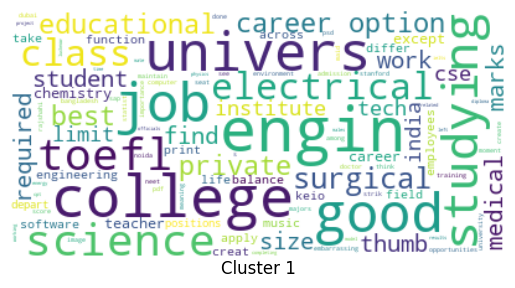

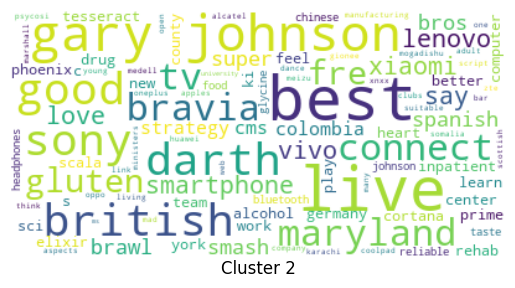

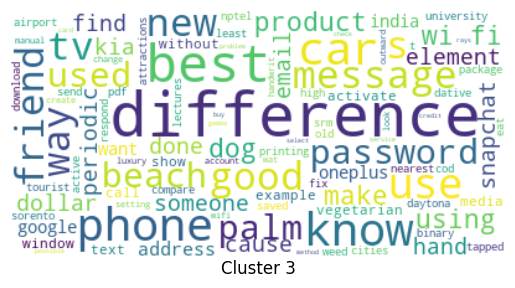

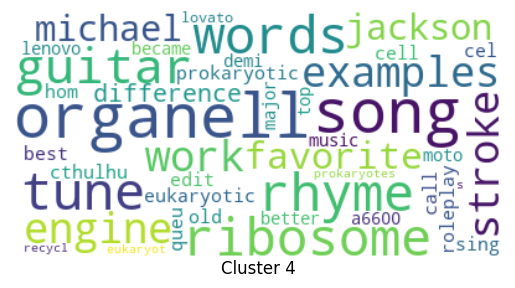

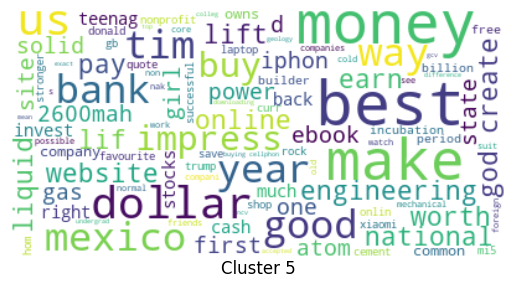

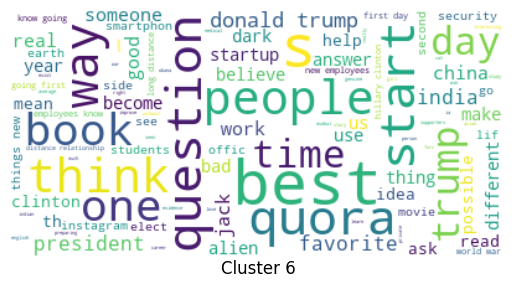

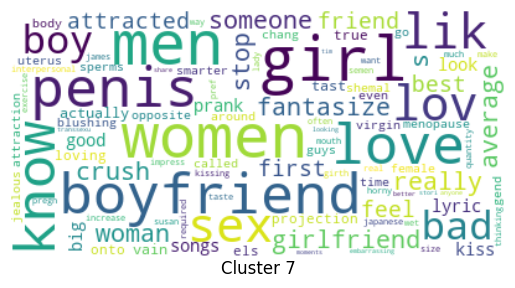

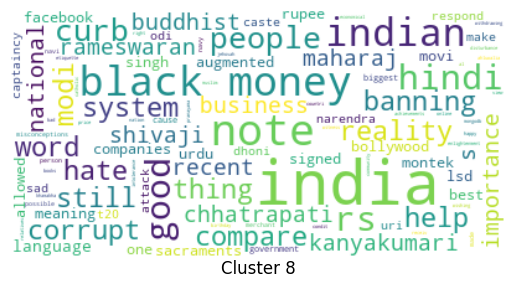

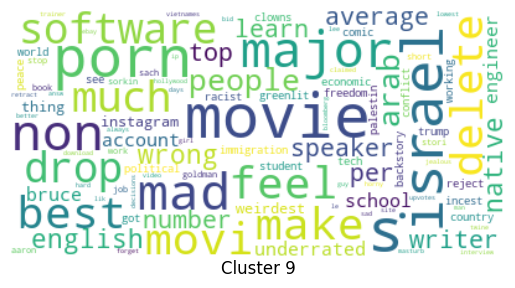

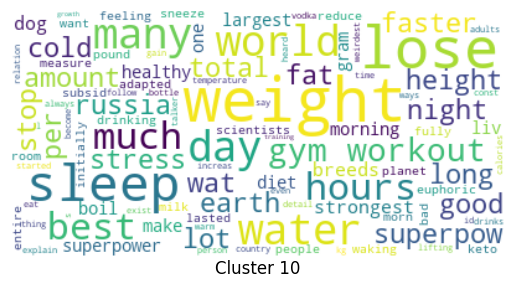

In [39]:
class Cluster:

    def __init__(self, frac, n_clusters):
        self.frac = frac
        self.n_clusters = n_clusters

    def preprocess(self):
        global data
        data = pd.read_csv('quora_duplicate_questions.tsv',
                           delimiter='\t').dropna(how='any'
                ).reset_index(drop=True)
        Preprocess(self.frac).run()
        Q1 = data[['qid1', 'question1_clean']]
        Q2 = data[['qid2', 'question2_clean']]
        Q1.columns = ['id', 'question']
        Q2.columns = ['id', 'question']
        data = pd.concat([Q1, Q2])
        emb = Bert_Embedding('distilbert-base-nli-stsb-quora-ranking',
                             '_bert_base', '_clean')
        vectors = [emb.vectors(q) for q in data['question']]
        return (emb, vectors)

    def run(self):
        (emb, vectors) = self.preprocess()
        model = Birch(branching_factor=50, n_clusters=self.n_clusters,
                      threshold=1.5)
        model.fit(vectors)
        data['cluster'] = [model.predict(emb.vectors(q).reshape(1, -1))
                           for q in data['question']]

    def explore(self):
        self.run()
        for i in range(int(max(data['cluster'])) + 1):
            txt = ''
            curr_cluster = data[data['cluster'] == i]
            for q in curr_cluster['question']:
                txt = txt + ' ' + str(q)
            wordcloud = WordCloud(max_font_size=50, max_words=100,
                                  background_color='white'
                                  ).generate(txt)
            pyplot.figure()
            pyplot.imshow(wordcloud, interpolation='bilinear')
            pyplot.axis('off')
            pyplot.title('Cluster ' + str(i + 1), y=-0.1)
            pyplot.show()

Cluster(0.001, 10).explore()